# 종합실습2 - 후판

- 00공장의 고객사에서 최근 들어 'Scale 불량 발생 증가'라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인 할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다.

## 데이터 확인

In [1]:
#패키지 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale,minmax_scale, robust_scale


In [2]:
matplotlib.rc('font',family='NanumGothic')
plt.rc('font',family='NanumGothic')

In [3]:
df_raw = pd.read_csv('SCALE불량.csv',encoding='cp949')
df_raw

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,PB563502,2008-08-02:13:35:36,불량,NK-KA,C0,20.14,3580,38639,21870,3호기,...,1172,72,1164,62,245,1155,1005,적용,8,2조
716,PB563503,2008-08-02:13:35:02,양품,NV-A32,C0,15.08,3212,48233,18340,2호기,...,1150,61,1169,61,238,1160,947,적용,10,1조
717,PB563504,2008-08-02:14:40:00,양품,NV-A32,C0,16.60,3441,43688,19590,2호기,...,1169,65,1163,77,247,1152,948,적용,10,4조
718,PB563505,2008-08-02:13:35:19,양품,LR-A,C0,15.59,3363,48740,80240,3호기,...,1179,86,1163,45,243,1154,940,적용,10,2조


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

In [5]:
#데이터의 분포 확인

df_raw.describe()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.204167,1149.666667,75.330556,300.563889,1139.570833,933.920833,8.319444
std,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,36.248696,17.571788,26.086390,45.390303,17.857121,107.863887,1.623252
min,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1102.000000,0.000000,5.000000
25%,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1122.750000,889.750000,6.000000
50%,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1144.000000,951.000000,8.000000
75%,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,85.250000,342.000000,1154.000000,994.250000,10.000000
max,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,251.000000,1185.000000,194.000000,398.000000,1175.000000,1078.000000,10.000000


## 데이터 정제

In [6]:
#결측치 확인 > 'HSB' 열에 '적용'또는 '미적용' 값 없음 확인

df_raw['HSB'][(df_raw['HSB']!='적용')|(df_raw['HSB']!='미적용')].count()

720

In [7]:
#결측치 제거 > 'Rolling_temp'가 0도 일 수 없으므로,

df_raw[df_raw['ROLLING_TEMP_T5']==0] #결측치 처리 해야 할 columns 확인
df_raw[df_raw['ROLLING_TEMP_T5']==0] = df_raw['ROLLING_TEMP_T5'].mean() # column의 전체 평균으로 채운다.
df_raw[df_raw['ROLLING_TEMP_T5']==0] #대체 확인 (처음과 다르게 빈 컬럼으로 나온다.)

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR


<AxesSubplot:>

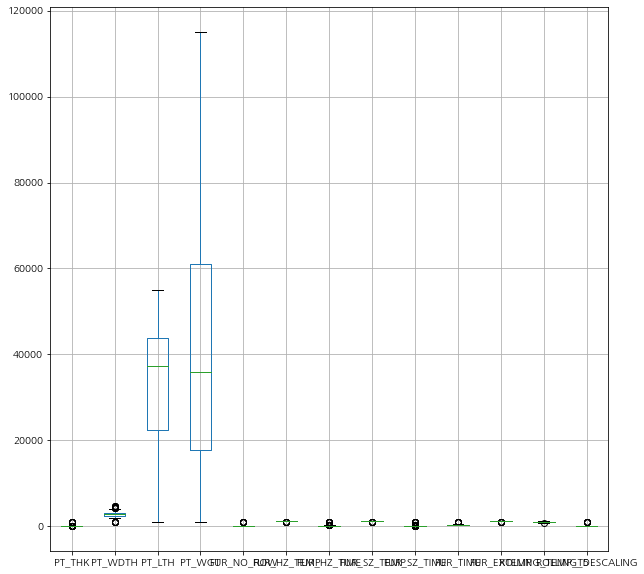

In [8]:
#이상치 확인

df_raw.boxplot(figsize=(10,10)) #ATM_PRESS column 때문에 y값의 간격이 커서 잘 보이지 않음

### 바로 보이는 이상치 값은 없다.

In [9]:
df_nodate = df_raw.drop(['PLATE_NO', 'ROLLING_DATE', 'SPEC'], axis=1, inplace=False) 

### 제품 규격(SPEC)은 주문 받을 때 원하는 규격이므로, 설명변수에 맞지 않는다고 판단, 데이터에서 제외한다. (교수님 조언)
### 데이터 분석을 위해  'PLATE_NO', 'ROLLING_DATE' 제외하고 데이터 분석한다.
### 강종은 뒤의 숫자는 사용 용도에 따른 것이고, T는 가속냉각열처리, C는 일반을 의미하므로, T 종류는 T로 
### C 종류는 C로 데이터 통일시킨다.


In [10]:
#STEEL_KIND 범주를 T와 C로 요약( 뒤의 숫자는 사용 용도에 따른 것이고, T는 가속냉각열처리, C는 일반을 의미하므로, )

for index, value in enumerate(df_nodate['STEEL_KIND']):
    if type(value) == str :
        if value.count('T') == 1 :
            df_nodate['STEEL_KIND'][index] = 'T'

        elif value.count('C') ==1:
            df_nodate['STEEL_KIND'][index] = 'C'

        else:
            df_nodate['STEEL_KIND'][index] = np.nan
    else : 
        df_nodate['STEEL_KIND'][index] = np.nan
        

<ipython-input-10-06bc4336738d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodate['STEEL_KIND'][index] = 'T'
<ipython-input-10-06bc4336738d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodate['STEEL_KIND'][index] = np.nan
<ipython-input-10-06bc4336738d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodate['STEEL_KIND'][index] = 'C'


In [11]:
df_nodate['STEEL_KIND'] #변화 확인

0      T
1      T
2      T
3      T
4      T
      ..
715    C
716    C
717    C
718    C
719    C
Name: STEEL_KIND, Length: 720, dtype: object

In [12]:
#null 값이 생성되었음을 알 수 있음.

df_nodate.isnull().sum()

SCALE                0
STEEL_KIND           6
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

In [13]:
#null값으로 대체된 값 확인

df_nodate[df_nodate['STEEL_KIND'].isnull()]

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,933.921,NaN,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
184,933.921,NaN,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
185,933.921,NaN,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
494,933.921,NaN,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
495,933.921,NaN,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
496,933.921,NaN,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921


In [14]:
#원본 값이 무엇이었는지 확인

df_raw.loc[[41, 184, 185, 494, 495, 496]]
#데이터가 의미있는 데이터가 아님을 확인 > steel_kind 의 값이 933.921인데 종류나 다른 뜻을 뜻하는 것이 아님.
#spec 데이터가 함께 잘못 복제된 것으로 예상 > 따라서, 해당 데이터 drop

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,933.921,933.921,933.921,933.921,933.921,933.920833,933.920833,933.920833,933.920833,933.921,...,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
184,933.921,933.921,933.921,933.921,933.921,933.920833,933.920833,933.920833,933.920833,933.921,...,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
185,933.921,933.921,933.921,933.921,933.921,933.920833,933.920833,933.920833,933.920833,933.921,...,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
494,933.921,933.921,933.921,933.921,933.921,933.920833,933.920833,933.920833,933.920833,933.921,...,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
495,933.921,933.921,933.921,933.921,933.921,933.920833,933.920833,933.920833,933.920833,933.921,...,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921
496,933.921,933.921,933.921,933.921,933.921,933.920833,933.920833,933.920833,933.920833,933.921,...,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.920833,933.921,933.920833,933.921


In [15]:
df_nodate.drop([41,184,185,494,495,496], axis=0, inplace=True) #null값을 갖는 raw drop
df_nodate.reset_index(drop=True, inplace=True) #index 초기화
df_nodate.tail(10) #index 초기화됨을 확인

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
704,양품,C,12.05,3095.0,53763.0,47220.0,2호기,2.0,1174.0,74.0,1159.0,61.0,238.0,1146.0,919.0,적용,10.0,2조
705,양품,C,12.05,3095.0,53763.0,47220.0,3호기,1.0,1179.0,65.0,1163.0,71.0,242.0,1154.0,913.0,적용,10.0,1조
706,양품,C,16.60,3528.0,32323.0,14860.0,3호기,2.0,1156.0,65.0,1160.0,72.0,244.0,1151.0,938.0,적용,10.0,1조
707,양품,C,18.11,3260.0,40586.0,37620.0,1호기,1.0,1174.0,66.0,1160.0,71.0,240.0,1148.0,965.0,적용,10.0,3조
708,양품,C,18.92,3401.0,41455.0,20940.0,1호기,2.0,1142.0,55.0,1151.0,86.0,246.0,1137.0,948.0,적용,10.0,4조
709,불량,C,20.14,3580.0,38639.0,21870.0,3호기,1.0,1172.0,72.0,1164.0,62.0,245.0,1155.0,1005.0,적용,8.0,2조
710,양품,C,15.08,3212.0,48233.0,18340.0,2호기,1.0,1150.0,61.0,1169.0,61.0,238.0,1160.0,947.0,적용,10.0,1조
711,양품,C,16.60,3441.0,43688.0,19590.0,2호기,2.0,1169.0,65.0,1163.0,77.0,247.0,1152.0,948.0,적용,10.0,4조
712,양품,C,15.59,3363.0,48740.0,80240.0,3호기,2.0,1179.0,86.0,1163.0,45.0,243.0,1154.0,940.0,적용,10.0,2조
713,양품,C,16.09,3400.0,54209.0,69840.0,3호기,1.0,1186.0,82.0,1169.0,45.0,239.0,1155.0,957.0,적용,10.0,2조


In [16]:
#float으로 이루어진 열에 str이 들어가면 object로 바로 info에서 확인 가능하여, 이상치를 확인 할 수 있으나
#STEEL_KIND 열처럼, str로 이루어진 열에 int나 float이 들어가면, 확인 불가능하여 이상치를 확인 할 수 없으므로,


df_nodate.info() #float으로 이루어진 열에 object가 들어간 경우 이상치 확인


# str로 이루어진 열에 int나 float형이 들어가 있는 이상치 확인,
columns = ['STEEL_KIND', 'FUR_NO', 'HSB', 'WORK_GR'] 
for i in columns :
    for index, value in enumerate(df_nodate[i]):
        if type(value) != str :
            print(i, index, value)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              714 non-null    object 
 1   STEEL_KIND         714 non-null    object 
 2   PT_THK             714 non-null    float64
 3   PT_WDTH            714 non-null    float64
 4   PT_LTH             714 non-null    float64
 5   PT_WGT             714 non-null    float64
 6   FUR_NO             714 non-null    object 
 7   FUR_NO_ROW         714 non-null    float64
 8   FUR_HZ_TEMP        714 non-null    float64
 9   FUR_HZ_TIME        714 non-null    float64
 10  FUR_SZ_TEMP        714 non-null    float64
 11  FUR_SZ_TIME        714 non-null    float64
 12  FUR_TIME           714 non-null    float64
 13  FUR_EXTEMP         714 non-null    float64
 14  ROLLING_TEMP_T5    714 non-null    float64
 15  HSB                714 non-null    object 
 16  ROLLING_DESCALING  714 non

### 프린트 되는 값이 없으므로, 이상치는 이제 더 이상 없다.

In [17]:
#수식이 잘 작동한 것이 맞는지, 원본 데이터인 df_raw에서 재확인

columns = ['STEEL_KIND', 'FUR_NO', 'HSB', 'WORK_GR']
for i in columns :
    for index, value in enumerate(df_raw[i]):
        if type(value) != str :
            print(i, index, value)

STEEL_KIND 41 933.9208333333333
STEEL_KIND 184 933.9208333333333
STEEL_KIND 185 933.9208333333333
STEEL_KIND 494 933.9208333333333
STEEL_KIND 495 933.9208333333333
STEEL_KIND 496 933.9208333333333
FUR_NO 41 933.9208333333333
FUR_NO 184 933.9208333333333
FUR_NO 185 933.9208333333333
FUR_NO 494 933.9208333333333
FUR_NO 495 933.9208333333333
FUR_NO 496 933.9208333333333
HSB 41 933.9208333333333
HSB 184 933.9208333333333
HSB 185 933.9208333333333
HSB 494 933.9208333333333
HSB 495 933.9208333333333
HSB 496 933.9208333333333
WORK_GR 41 933.9208333333333
WORK_GR 184 933.9208333333333
WORK_GR 185 933.9208333333333
WORK_GR 494 933.9208333333333
WORK_GR 495 933.9208333333333
WORK_GR 496 933.9208333333333


### 삭제했던 41,184,185,494,495,496 행에서만 이상치가 발생했던 것을 알 수 있다.
### 따라서, 위 행들이 지워진 df_nodate 데이터에선 따로 처리할 이상치가 이제 더 이상 남아있지 않다.

In [18]:
#결측치, 이상치 처리한 데이터 재확인
print(df_nodate.head())
print(df_nodate.info())

  SCALE STEEL_KIND  PT_THK  PT_WDTH   PT_LTH   PT_WGT FUR_NO  FUR_NO_ROW  \
0    양품          T   32.25   3707.0  15109.0  14180.0    1호기         1.0   
1    양품          T   32.25   3707.0  15109.0  14180.0    1호기         2.0   
2    양품          T   33.27   3619.0  19181.0  18130.0    2호기         1.0   
3    양품          T   33.27   3619.0  19181.0  18130.0    2호기         2.0   
4    양품          T   38.33   3098.0  13334.0  12430.0    3호기         1.0   

   FUR_HZ_TEMP  FUR_HZ_TIME  FUR_SZ_TEMP  FUR_SZ_TIME  FUR_TIME  FUR_EXTEMP  \
0       1144.0        116.0       1133.0         59.0     282.0      1125.0   
1       1144.0        122.0       1135.0         53.0     283.0      1120.0   
2       1129.0        116.0       1121.0         55.0     282.0      1106.0   
3       1152.0        125.0       1127.0         68.0     316.0      1113.0   
4       1140.0        134.0       1128.0         48.0     314.0      1118.0   

   ROLLING_TEMP_T5 HSB  ROLLING_DESCALING WORK_GR  
0            934

# 
## 잠재적인 인자 (가설) 설정

- 가열로 가열대 온도가 높을수록, scale이 더 많이 발생한다.
- 가열로 균열대 온도가 높을수록, scale이 더 많이 발생한다.
- 가열로 추출 온도가 높을수록, scale이 더 많이 발생한다.
- Hot scale breaker가 미적용 될 수록, scale이 더 많이 발생한다.
- 사상 압연 온도가 높을수록, scale이 더 많이 발생한다.
- 압연간 Descaling 횟수가 높을수록, scale이 더 많이 발생한다.
- 판 두께가 얇을수록, scale이 더 많이 발생한다.
- 작업조에 따라, scale이 다르게 발생한다.
- 강종 종류에 따라, scale이 다르게 발생한다.

# 그래프 분석 
### 1. 히스토그램 분석

array([[<AxesSubplot:title={'center':'PT_THK'}>,
        <AxesSubplot:title={'center':'PT_WDTH'}>,
        <AxesSubplot:title={'center':'PT_LTH'}>,
        <AxesSubplot:title={'center':'PT_WGT'}>],
       [<AxesSubplot:title={'center':'FUR_NO_ROW'}>,
        <AxesSubplot:title={'center':'FUR_HZ_TEMP'}>,
        <AxesSubplot:title={'center':'FUR_HZ_TIME'}>,
        <AxesSubplot:title={'center':'FUR_SZ_TEMP'}>],
       [<AxesSubplot:title={'center':'FUR_SZ_TIME'}>,
        <AxesSubplot:title={'center':'FUR_TIME'}>,
        <AxesSubplot:title={'center':'FUR_EXTEMP'}>,
        <AxesSubplot:title={'center':'ROLLING_TEMP_T5'}>],
       [<AxesSubplot:title={'center':'ROLLING_DESCALING'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

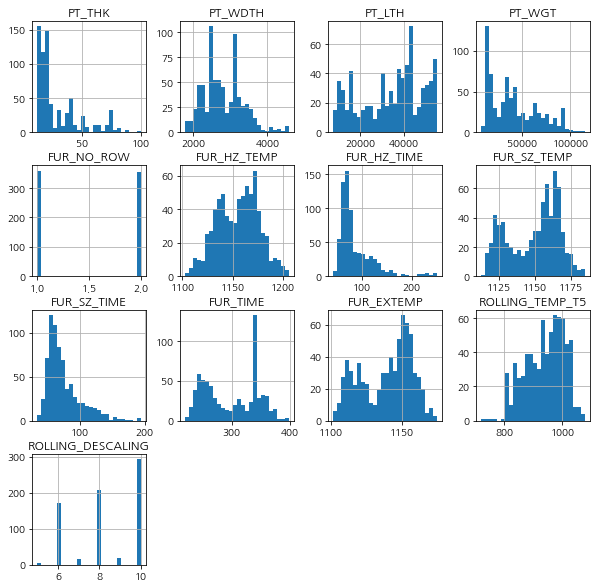

In [19]:
bins_ = int(np.sqrt(714)) #bins값은 데이터 총 개수의 제곱근값이다.(실무에서 bins값 맞추는 게 중요!!)

df_nodate.hist(figsize=(10,10), bins=bins_)

- PT_THK, PT_WGT, FUR_HZ_TIME, FUR_SZ_TIME 의 히스토그램은 왼쪽으로 치우친 형태이어서, 변환 처리가 필요하다.
- ROLLING_TEMP_T5 의 히스토그램은 오른쪽으로 치우친 형태이어서, 변환 처리가 필요하다.
- PT_LTH, FUR_SZ_TEMP 의 히스토그램은 쌍봉우리 형태여서, 층별화 처리가 필요하다.

In [20]:
def fun_plot_hist(data, var):
    plt.hist(data[data["SCALE"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["SCALE"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()

    
# 실행 : fun_plot_hist(df_raw, "PT_THK")

def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))


# 실행 : fun_print_crosstab(df_raw, "FUR_NO")

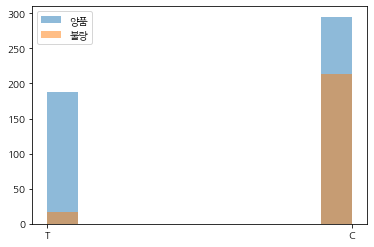

In [21]:
columns=list(df_nodate.columns [1:]) #columns명을 리스트로 가져와서
columns1 = ['STEEL_KIND','FUR_NO','HSB', 'WORK_GR'] #범주형
columns2 = ['PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT','FUR_NO_ROW', 'FUR_HZ_TEMP', 'FUR_HZ_TIME', 
            'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'ROLLING_DESCALING']
#연속형 리스트로 나눔

#STEEL_KIND
fun_plot_hist(df_nodate, columns1[0])

### STEEL_KIND의 T는 포스코 특수 기법인 가속냉각열 처리를 한 것이고, C는 일반 압연이다.
### 위 표를 통해, 강종 종류에 따라 scale이 다르게 나타남을 알 수 있고, 가설이 맞음을 알 수 있다.

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   70   88
양품      166  166  151

FUR_NO    1호기    2호기    3호기
SCALE                      
불량      0.305  0.297  0.368
양품      0.695  0.703  0.632


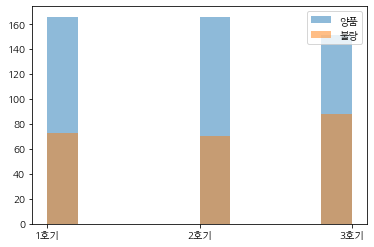

In [22]:
#FUR_NO
fun_plot_hist(df_nodate, columns1[1])
fun_print_crosstab(df_nodate,columns1[1])

### FUR_NO는 가열로의 호기이다. 1호기, 2호기, 3호기가 존재하며, 위 표를 통해, 
### 가열로의 호기에 따라 scale이 다르게 나타나지 않음을 알 수 있고, 가설이 틀렸음을 알 수 있다.

HSB    미적용   적용
SCALE          
불량      33  198
양품       0  483

HSB    미적용     적용
SCALE            
불량     1.0  0.291
양품     0.0  0.709


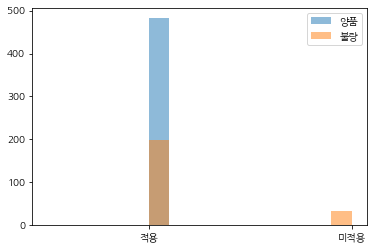

In [23]:
#HSB
fun_plot_hist(df_nodate, columns1[2])
fun_print_crosstab(df_nodate,columns1[2])

### HSB는 가열로에서 압연 과정으로 넘어가기 전에, scale을 처리하는 과정이고,
### HSB를 적용해도, 압연중 생기는 scale 때문에, 양품과 불량의 비율이 반반씩 나타남을 알 수 있고,
### 미적용하면, 아예 압연 과정으로 넘어가기 전부터, scale을 가지고 있기 때문에, 무조건 불량이 나온다.
### 따라서, HSB 적용에 따라 scale이 다르게 나타남을 알 수 있고, 가설이 맞았음을 알 수 있다.

In [24]:
# HSB 값이 미적용이면, 무조건 불량으로 나오기 때문에, HSB가 미적용인 부분은 HSB의 영향으로 무의미한 값임을 알 수 있다.
# 따라서, 전처리에 이상값으로 확인되지 않았지만, 이 과정에서 확인 되었으므로, HSB의 미적용 부분을 제거한다.

df_nodate[df_nodate['HSB']=='미적용'] #미적용 값의 데이터 확인
a= list(df_nodate[df_nodate['HSB']=='미적용'].index) #미적용 값의 데이터의 인덱스 리스트에 저장
print(a) #인덱스 번호 리스트

df_nodate.drop(a, axis=0, inplace=True) #미적용 데이터 값 지움 확인
df_nodate.tail(20) #지워진 것을 확인 가능

[70, 78, 84, 111, 162, 243, 247, 287, 300, 324, 327, 338, 358, 360, 376, 385, 390, 400, 435, 443, 465, 489, 499, 508, 529, 545, 559, 585, 586, 602, 615, 677, 694]


,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
693,양품,C,12.05,2855.0,51765.0,27960.0,3호기,1.0,1172.0,70.0,1163.0,71.0,252.0,1153.0,936.0,적용,10.0,3조
695,양품,C,12.05,2835.0,54816.0,14700.0,1호기,1.0,1177.0,60.0,1163.0,65.0,251.0,1157.0,887.0,적용,10.0,1조
696,양품,C,12.05,2855.0,52321.0,28260.0,1호기,2.0,1159.0,54.0,1156.0,74.0,252.0,1144.0,894.0,적용,10.0,3조
697,양품,C,12.05,2855.0,52913.0,28580.0,2호기,1.0,1160.0,60.0,1159.0,77.0,262.0,1146.0,894.0,적용,10.0,2조
698,양품,C,12.05,2855.0,53284.0,28780.0,2호기,2.0,1160.0,69.0,1160.0,65.0,231.0,1148.0,888.0,적용,10.0,4조
699,양품,C,12.05,2855.0,52913.0,28580.0,3호기,1.0,1185.0,79.0,1163.0,58.0,249.0,1154.0,902.0,적용,10.0,2조
700,양품,C,12.56,2858.0,51457.0,14500.0,3호기,2.0,1174.0,65.0,1168.0,58.0,249.0,1153.0,908.0,적용,10.0,2조
701,양품,C,12.05,3088.0,50530.0,14760.0,1호기,1.0,1183.0,66.0,1166.0,68.0,257.0,1159.0,896.0,적용,10.0,4조
702,양품,C,12.05,3018.0,50056.0,14290.0,1호기,2.0,1173.0,55.0,1164.0,78.0,259.0,1152.0,891.0,적용,10.0,2조
703,양품,C,12.05,3185.0,52244.0,31480.0,2호기,1.0,1184.0,61.0,1161.0,63.0,262.0,1153.0,916.0,적용,10.0,3조


In [25]:
df_nodate.reset_index(drop=True, inplace=True) #index 초기화
df_nodate.tail(20) #index 초기화 된 것을 확인 가능

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
661,양품,C,12.05,2855.0,51765.0,27960.0,3호기,1.0,1172.0,70.0,1163.0,71.0,252.0,1153.0,936.0,적용,10.0,3조
662,양품,C,12.05,2835.0,54816.0,14700.0,1호기,1.0,1177.0,60.0,1163.0,65.0,251.0,1157.0,887.0,적용,10.0,1조
663,양품,C,12.05,2855.0,52321.0,28260.0,1호기,2.0,1159.0,54.0,1156.0,74.0,252.0,1144.0,894.0,적용,10.0,3조
664,양품,C,12.05,2855.0,52913.0,28580.0,2호기,1.0,1160.0,60.0,1159.0,77.0,262.0,1146.0,894.0,적용,10.0,2조
665,양품,C,12.05,2855.0,53284.0,28780.0,2호기,2.0,1160.0,69.0,1160.0,65.0,231.0,1148.0,888.0,적용,10.0,4조
666,양품,C,12.05,2855.0,52913.0,28580.0,3호기,1.0,1185.0,79.0,1163.0,58.0,249.0,1154.0,902.0,적용,10.0,2조
667,양품,C,12.56,2858.0,51457.0,14500.0,3호기,2.0,1174.0,65.0,1168.0,58.0,249.0,1153.0,908.0,적용,10.0,2조
668,양품,C,12.05,3088.0,50530.0,14760.0,1호기,1.0,1183.0,66.0,1166.0,68.0,257.0,1159.0,896.0,적용,10.0,4조
669,양품,C,12.05,3018.0,50056.0,14290.0,1호기,2.0,1173.0,55.0,1164.0,78.0,259.0,1152.0,891.0,적용,10.0,2조
670,양품,C,12.05,3185.0,52244.0,31480.0,2호기,1.0,1184.0,61.0,1161.0,63.0,262.0,1153.0,916.0,적용,10.0,3조


In [26]:
df_nodate[df_nodate['HSB']=='미적용'] #미적용 값의 데이터 없음 확인

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR


### 이상치로 판단 후, 제거 완료. 앞의 히스토그램을 다시 돌려도 비슷해서 결과 해석은 상관 없으므로, 굳이 다시 돌리지 않는다.

WORK_GR   1조   2조   3조   4조
SCALE                      
불량        59   39   45   55
양품       121  119  115  128

WORK_GR     1조     2조     3조     4조
SCALE                              
불량       0.328  0.247  0.281  0.301
양품       0.672  0.753  0.719  0.699


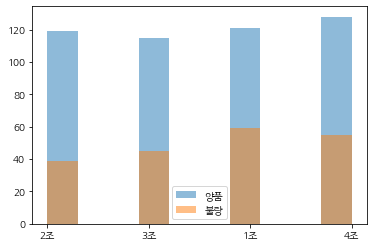

In [27]:
#FWORK_GR
fun_plot_hist(df_nodate, columns1[3])
fun_print_crosstab(df_nodate,columns1[3])

### FWORK_GR은 작업조이다. 위 표를 통해, 2조의 결과물이 제일 양품이 많은 것을 알 수 있고,
### 1조가 불량의 비율이 제일 높은 것을 확인 할 수 있다. 하지만, 그 차이가 크지 않아서,
### FWORK_GR에 따라 scale이 다르게 나타난다는 가설을 맞다고 하기 어렵다.

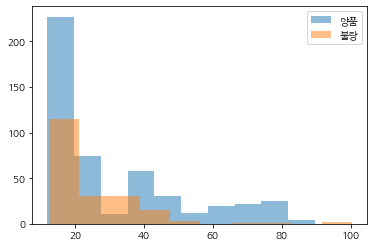

In [28]:
#PT_THK

fun_plot_hist(df_nodate, columns2[0])

### PT_THK는 plate의 두께이다. 위 표를 통해, plate의 두께가 20 이하로 그 값이 작으면,
### 불량률이 급격히 높아지는 것을 알 수 있다. 따라서, PT_THK에 따라 scale이 다르게 나타난다는 가설을 맞다고 할 수 있다.

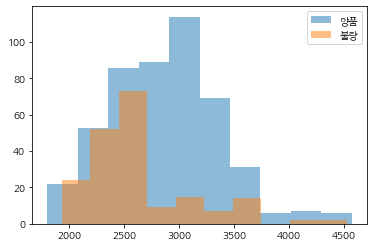

In [29]:
#PT_WDTH

fun_plot_hist(df_nodate, columns2[1])

### PT_WDTH는 plate의 폭이다. 위 표를 통해, plate의 폭이 2500 이하로 그 값이 작으면,
### 불량률이 높아지는 것을 알 수 있다. 따라서, PT_WDTH에 따라 scale이 다르게 나타난다고 말할 수 있을 것 같아 보인다.

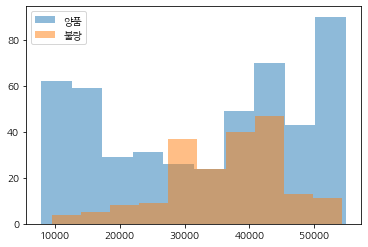

In [30]:
#PT_LTH

fun_plot_hist(df_nodate, columns2[2])

### PT_LTH는 plate의 길이이다. 위 표를 통해, plate의 폭이 30000 이상 45000 이하이면,
### 불량률이 높아지는 것을 알 수 있다. 따라서, PT_LTH에 따라 scale이 다르게 나타난다고 말할 수 있을 것 같아 보인다.

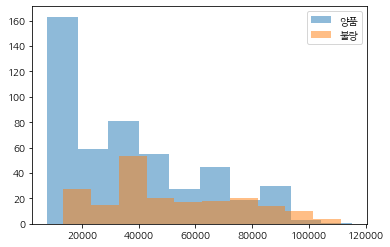

In [31]:
#PT_WGT

fun_plot_hist(df_nodate, columns2[3])

### PT_WGT는 plate의 중량이다. 위 표를 통해, 불량품의 차이가 불규칙한 것을 알 수 있다.
### 따라서, PT_WGT는 scale에 크게 영향을 끼치지 않는 것 같아 보인다.

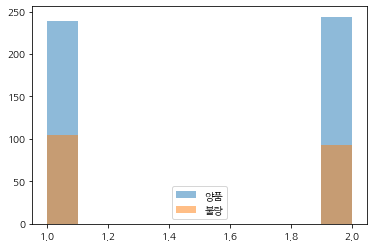

In [32]:
#FUR_NO_ROW

fun_plot_hist(df_nodate, columns2[4])

### FUR_NO_ROW는 가열로 작업 순번이다. 위 표를 통해, 1번과 2번의 값이 거의 같은 것을 알 수 있다.
### 따라서, FUR_NO_ROW는 scale에 영향을 끼치지 않는 것 같아 보인다.

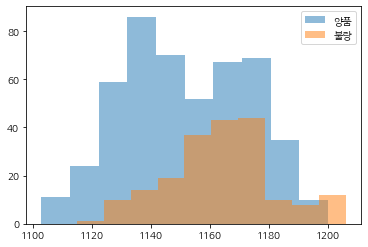

In [33]:
#FUR_HZ_TEMP

fun_plot_hist(df_nodate, columns2[5])

### FUR_HZ_TEMP는 가열로 가열대의 온도이다. 위 표를 통해, 1150 이상 1170 이하이면,
### 불량률이 높아지는 것을 알 수 있다. 따라서, FUR_HZ_TEMP에 따라 scale이 다르게 나타난다는 가설을 맞다고 할 수 있다.¶

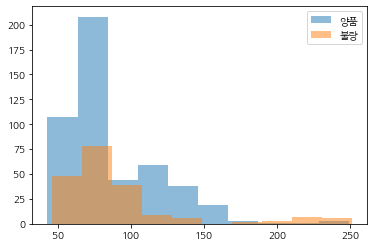

In [34]:
#FUR_HZ_TIME

fun_plot_hist(df_nodate, columns2[6])

### FUR_HZ_TIME는 가열로 가열대의 시간이다. 위 표를 통해, 값이 작아지면, 불량률이 높아지는 것을 알 수 있다.
### 따라서, FUR_HZ_TIME에 따라 scale이 다르게 나타난다고 말할 수 있을 것 같아 보인다.

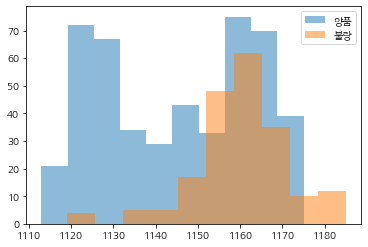

In [35]:
#FUR_SZ_TEMP

fun_plot_hist(df_nodate, columns2[7])

### FUR_SZ_TEMP는 가열로 균열대의 온도이다. 위 표를 통해, 그 값이 높아지면
### 불량률이 높아지는 것을 알 수 있다. 따라서, FUR_SZ_TEMP에 따라 scale이 다르게 나타난다는 가설을 맞다고 할 수 있다.¶

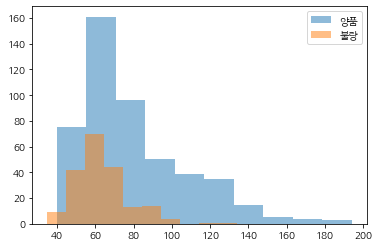

In [36]:
#FUR_SZ_TIME

fun_plot_hist(df_nodate, columns2[8])

### FUR_SZ_TIME는 가열로 균열대의 시간이다. 위 표를 통해, 값이 작아지면, 불량률이 높아지는 것을 알 수 있다.
### 따라서, FUR_SZ_TIME에 따라 scale이 다르게 나타난다고 말할 수 있을 것 같아 보인다.

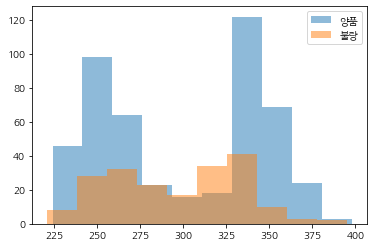

In [37]:
#FUR_TIME

fun_plot_hist(df_nodate, columns2[9])

### FUR_TIME는 가열로 시간이다. 위 표를 통해, 양품과 불량품의 그래프 배치가 비슷함을 알 수 있다.
### 따라서, FUR_TIME에 따라 scale이 다르게 나타난다고 말할 수 없어 보인다.

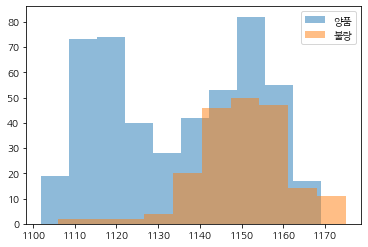

In [38]:
#FUR_EXTEMP


fun_plot_hist(df_nodate, columns2[10])

### FUR_EXTEMP는 가열로 추출온도이다. 위 표를 통해, 값이 커지면, 불량률이 높아지는 것을 알 수 있다.
### 따라서, FUR_SZ_TIME에 따라 scale이 다르게 나타난다고 말할 수 있다.

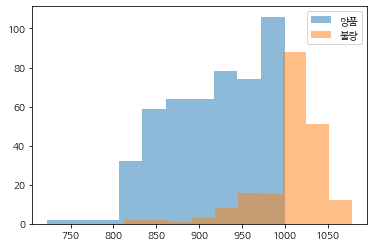

In [39]:
#ROLLING_TEMP_T5

fun_plot_hist(df_nodate, columns2[11])

### ROLLING_TEMP_T5는 압연온도이다. 위 표를 통해, 값이 커지면, 불량률이 높아지는 것을 알 수 있다.
### 따라서, ROLLING_TEMP_T5에 따라 scale이 다르게 나타난다는 가설을 맞다고 할 수 있다.

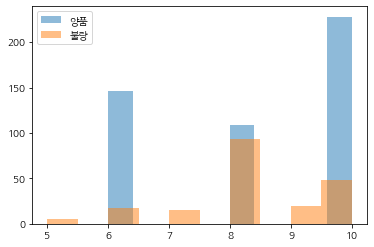

In [40]:
#ROLLING_DESCALING

fun_plot_hist(df_nodate, columns2[12])

### ROLLING_DESCALING는 압연 중 Descaling 횟수이다. 위 표를 통해, 그 횟수가 8일 때 불량품이 제일 많은 것을 알 수 있다.
### 따라서, ROLLING_DESCALING에 따라 scale이 다르게 나타난다고 가설에 대해 정확히 검증하기 어려워 보인다.

# 
### 2. 산점도 분석

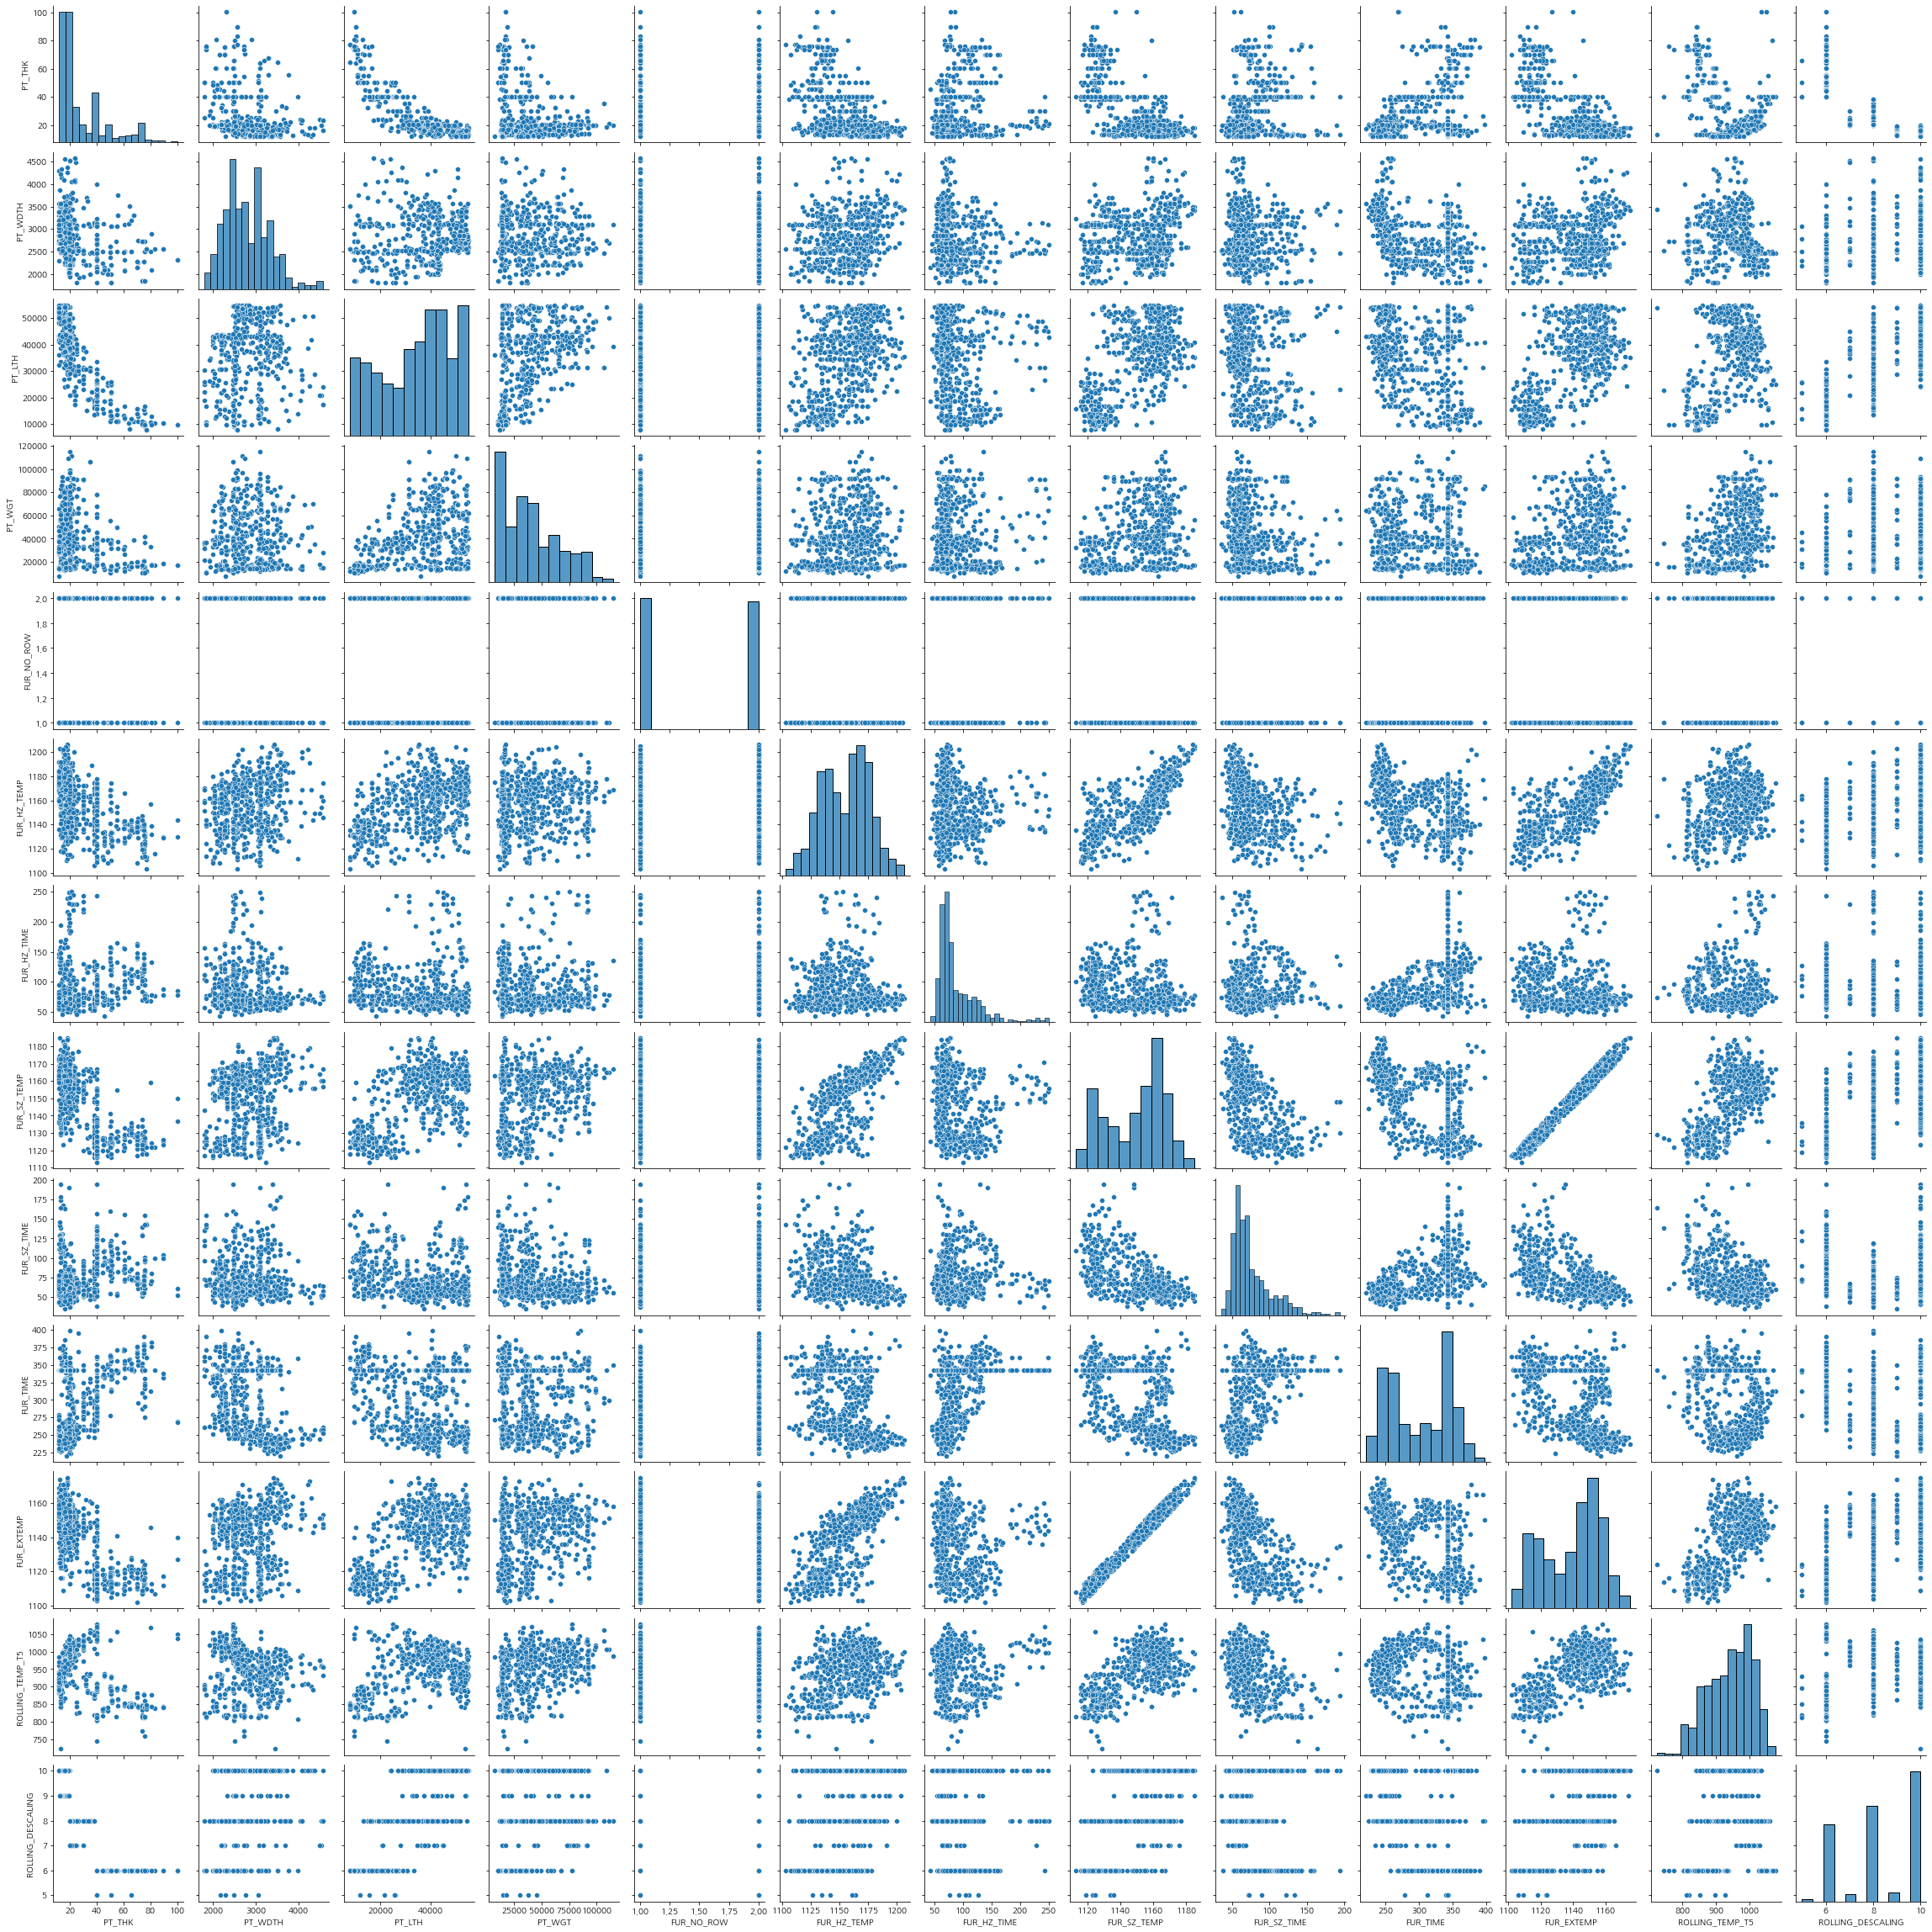

In [41]:
#전체 변수 사이의 상관관계 확인 Scatter Matrix

sns.pairplot(df_nodate)

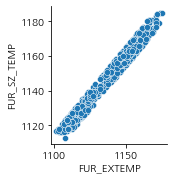

In [42]:
sns.pairplot(df_nodate, y_vars='FUR_SZ_TEMP', x_vars='FUR_EXTEMP',  diag_kind=None)

- 가열로 균열대 온도와 추출온도의 상관관계가 완벽히 선형관계로 보이므로, 다중공선성으로 볼 수 있다.
- 다중공선성이 있을 때, 하나의 변수를 삭제해야 한다.

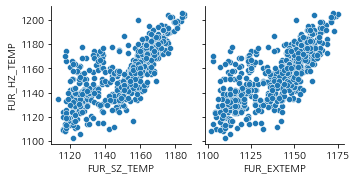

In [43]:
sns.pairplot(df_nodate, y_vars='FUR_HZ_TEMP', x_vars=['FUR_SZ_TEMP' ,'FUR_EXTEMP'], diag_kind=None)

- 가열로 가열대 온도와 가열로 균열대 온도, 추출온도의 상관관계가 선형관계로 보이므로, 다중공선성으로 볼 수 있다.
- 다중공선성이 있을 때, 해당하는 변수 중 하나를 삭제해야 한다.

In [44]:
#상관계수로 재확인

df_nodate.corr()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
PT_THK,1.000000,-0.311570,-0.859754,-0.388648,-0.030583,-0.515907,0.176736,-0.687729,0.264659,0.401062,-0.681267,-0.495343,-0.834758
PT_WDTH,-0.311570,1.000000,0.115863,0.025322,0.002814,0.176704,-0.133505,0.218611,-0.050496,-0.385638,0.206551,-0.127166,0.341828
PT_LTH,-0.859754,0.115863,1.000000,0.444713,0.001435,0.459286,-0.095018,0.635174,-0.220388,-0.241440,0.631762,0.429648,0.803284
PT_WGT,-0.388648,0.025322,0.444713,1.000000,-0.017913,0.145202,0.008230,0.352581,-0.191121,-0.048070,0.355877,0.422987,0.227229
FUR_NO_ROW,-0.030583,0.002814,0.001435,-0.017913,1.000000,0.020713,-0.005047,0.014752,0.055933,0.012978,0.018474,0.008982,0.040308
FUR_HZ_TEMP,-0.515907,0.176704,0.459286,0.145202,0.020713,1.000000,-0.105115,0.774423,-0.323343,-0.336303,0.757314,0.358809,0.458930
FUR_HZ_TIME,0.176736,-0.133505,-0.095018,0.008230,-0.005047,-0.105115,1.000000,-0.202877,0.068511,0.483871,-0.189721,-0.004146,-0.149317
FUR_SZ_TEMP,-0.687729,0.218611,0.635174,0.352581,0.014752,0.774423,-0.202877,1.000000,-0.569638,-0.464465,0.984966,0.671319,0.633829
FUR_SZ_TIME,0.264659,-0.050496,-0.220388,-0.191121,0.055933,-0.323343,0.068511,-0.569638,1.000000,0.502242,-0.567470,-0.478087,-0.274384
FUR_TIME,0.401062,-0.385638,-0.241440,-0.048070,0.012978,-0.336303,0.483871,-0.464465,0.502242,1.000000,-0.456884,-0.208812,-0.355505


In [45]:
df_nodate.corr() > 0.7

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
PT_THK,True,False,False,False,False,False,False,False,False,False,False,False,False
PT_WDTH,False,True,False,False,False,False,False,False,False,False,False,False,False
PT_LTH,False,False,True,False,False,False,False,False,False,False,False,False,True
PT_WGT,False,False,False,True,False,False,False,False,False,False,False,False,False
FUR_NO_ROW,False,False,False,False,True,False,False,False,False,False,False,False,False
FUR_HZ_TEMP,False,False,False,False,False,True,False,True,False,False,True,False,False
FUR_HZ_TIME,False,False,False,False,False,False,True,False,False,False,False,False,False
FUR_SZ_TEMP,False,False,False,False,False,True,False,True,False,False,True,False,False
FUR_SZ_TIME,False,False,False,False,False,False,False,False,True,False,False,False,False
FUR_TIME,False,False,False,False,False,False,False,False,False,True,False,False,False


### 상관계수 값이 높은 것은 앞서 구한 가열로 균열대 온도와 추출온도의 상관관계와 가열로 가열대 온도와 가열로 균열대 온도,
### 추출온도의 상관관계가 선형관계만임을 다시 정확히 확인 할 수 있다.
### 따라서, 로지스틱 회귀분석 모델을 할 때는, 위의 다중공선성이 보이는 설명변수를 제거하여 실행해야 한다.
### 지금의 경우, 로지스틱 회귀분석의 값이 근거있지 않아, 그 내용을 생략한다.


# 
## 비선형회귀 (기본 옵션으로 먼저 모델 생성해보기)
### 1. 의사결정 나무 (Decision Tree)

In [46]:
#패키지 불러오기

import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [47]:
#목표변수와 설명변수 지정

df_raw_x=df_nodate.drop('SCALE', axis=1, inplace=False) #설명변수 지정
df_raw_y=df_nodate["SCALE"] #목표변수 지정

In [48]:
#데이터 구성하기 - 더미변수 생성
#get_dummies : 데이터의 문자형 변수에 대한 더미변수 생성

df_raw_dummy = pd.get_dummies(df_raw_x)

#더미 변수로 생성된 데이터 확인
df_raw_dummy.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,STEEL_KIND_C,STEEL_KIND_T,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,32.25,3707.0,15109.0,14180.0,1.0,1144.0,116.0,1133.0,59.0,282.0,...,0,1,1,0,0,1,0,1,0,0
1,32.25,3707.0,15109.0,14180.0,2.0,1144.0,122.0,1135.0,53.0,283.0,...,0,1,1,0,0,1,0,1,0,0
2,33.27,3619.0,19181.0,18130.0,1.0,1129.0,116.0,1121.0,55.0,282.0,...,0,1,0,1,0,1,0,0,1,0
3,33.27,3619.0,19181.0,18130.0,2.0,1152.0,125.0,1127.0,68.0,316.0,...,0,1,0,1,0,1,0,0,1,0
4,38.33,3098.0,13334.0,12430.0,1.0,1140.0,134.0,1128.0,48.0,314.0,...,0,1,0,0,1,1,1,0,0,0


In [49]:
#데이터 구성하기

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_dummy, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (476, 23)
train data Y size : (476,)
test data X size : (205, 23)
test data Y size : (205,)


In [50]:
#기본 옵션으로 모델 생성 

tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)

#train의 정확도
print('Accuracy on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x,df_train_y)))
#test의 정확도
print('Accuracy on test set : {:.3f}'.format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set : 1.000
Accuracy on test set : 0.966


### DT 모델의 정확도는 trian 100%, test 96.6%로, train 데이터는 과대적합 경향성을 보이나, 일반적으로 좋은 모델이다.

### 2. 랜덤 포레스트 (Random Forest)

In [51]:
#패키지 추가 불러오기
from sklearn.ensemble import RandomForestClassifier

In [52]:
#기본 옵션으로 모델 생성
#랜덤 포레스트 모델 생성 
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x,df_train_y)

#train data 정확도
print('Accuracy on training set :{:.3f}'.format(rf_uncustomized.score(df_train_x,df_train_y)))
#test data 정확도
print('Accuracy on test set :{:.3f}'.format(rf_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set :1.000
Accuracy on test set :0.946


### RF 모델의 정확도는 trian 100%, test 94.6%로 모델은 train 데이터에 과대적합이다.

### 3. 그래디언트 부스팅 (Gradient Boosting)

In [54]:
#패키지 추가로 불러오기

from sklearn.ensemble import GradientBoostingClassifier

In [55]:
#기본 옵션으로 모델 생성
#그래디언트 부스팅 모델 생성 
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x,df_train_y)

#train data 정확도
print('Accuracy on training set :{:.3f}'.format(gb_uncustomized.score(df_train_x,df_train_y)))
#test data 정확도
print('Accuracy on test set :{:.3f}'.format(gb_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set :1.000
Accuracy on test set :0.995


### GB 모델의 정확도는 trian 100%, test 99.5%로 모델은 train 데이터가 과대적합의 경향성을 보이나,
### Train 데이터, Test 데이터의 정확도 모두 높고, 일반성까지 확보 하였으므로 좋은 모델이다.
### 따라서, 최적 모델로 그래디언트 부스팅을 선정한다.

# 
## 비선형회귀 (Parameter 설정)
- 최적 모델로 그래디언트 부스팅을 선정하고, 그에 따른 parameter를 설정한다.

In [66]:
#모델 parameter 조정
#learning_rate : 학습률 변경에 따른 모델 성능

train_accuracy =[] #train 설명력 결과 저장
test_accuracy=[] #test 설명력 결과 저장

para_lr = [lr*0.1 for lr in range(1,10)]
for v_learning_rate in para_lr :
    gb=GradientBoostingClassifier(random_state=1234, learning_rate =v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
#결과 저장, 모델 설명력 확인
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] =para_lr
df_accuracy_lr['TrainAccuracy'] =train_accuracy
df_accuracy_lr['TestAccuracy'] =test_accuracy
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,1.0,0.995
1,0.2,1.0,0.995
2,0.3,1.0,0.995
3,0.4,1.0,0.995
4,0.5,1.0,0.990
5,0.6,1.0,0.990
6,0.7,1.0,0.990
7,0.8,1.0,0.990
8,0.9,1.0,0.990


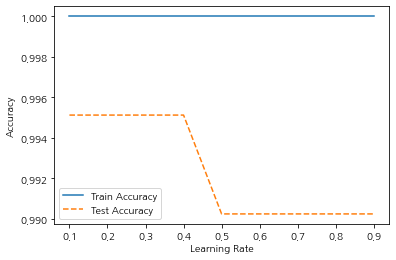

In [67]:
#모델 설명력 그래프로 확인

plt.plot(para_lr, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('Accuracy');plt.xlabel('Learning Rate')
plt.legend()

### 학습률 증가에 따라, 모델의 정확도는 증가하는데, train 데이터는 이미 100%이므로, 성능이 특별히 개선되지 않아,
### 데이터의 성능을 따라, 0.1 선택

In [64]:
#모델 parameter 조정
#n_estimators : 트리 수 변경에 따른 모델 성능

train_accuracy =[] #train 설명력 결과 저장
test_accuracy=[] #test 설명력 결과 저장

para_n_tree = [n_tree*10 for n_tree in range(1,16)]
for v_n_estimators in para_n_tree :
    gb=GradientBoostingClassifier(random_state=1234, n_estimators=v_n_estimators, learning_rate =0.1)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
#결과 저장, 모델 설명력 확인
df_accuracy_n = pd.DataFrame()
df_accuracy_n['Estimators'] =para_n_tree
df_accuracy_n['TrainAccuracy'] =train_accuracy
df_accuracy_n['TestAccuracy'] =test_accuracy
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.968,0.966
1,20,0.968,0.966
2,30,0.979,0.966
3,40,0.987,0.971
4,50,1.000,0.990
5,60,1.000,0.990
6,70,1.000,0.990
7,80,1.000,0.995
8,90,1.000,0.995
9,100,1.000,0.995


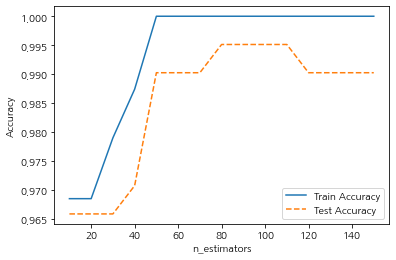

In [65]:
#모델 설명력 그래프로 확인

plt.plot(para_n_tree, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('Accuracy');plt.xlabel('n_estimators')
plt.legend()

### 생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하나, 트리 개수를 감소시키면 일반적으로 과대적합을 방지하므로,
### train/test 데이터의 성능 변화를 고려하여, 20 선택

In [83]:
#모델 parameter 조정
#max_depth : 최대 깊이 변경에 따른 모델 성능

train_accuracy =[] #train 설명력 결과 저장
test_accuracy=[] #test 설명력 결과 저장

para_depth = [depth for depth in range(1,11)]
for v_max_depth in para_depth :
    gb=GradientBoostingClassifier(random_state=1234, n_estimators=20, learning_rate =0.1, max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
#결과 저장, 모델 설명력 확인
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] =para_depth
df_accuracy_depth['TrainAccuracy'] =train_accuracy
df_accuracy_depth['TestAccuracy'] =test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.937,0.912
1,2,0.964,0.951
2,3,0.968,0.966
3,4,0.977,0.966
4,5,0.994,0.980
5,6,1.000,0.976
6,7,1.000,0.985
7,8,1.000,0.976
8,9,1.000,0.980
9,10,1.000,0.980


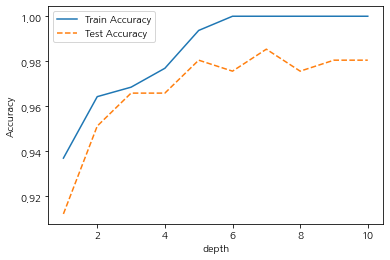

In [84]:
#모델 설명력 그래프로 확인

plt.plot(para_depth, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('Accuracy');plt.xlabel('depth')
plt.legend()

### 최대 깊이 증가에 따라 모델의 정확도는 증가하다 감소하는 경향을 보이며, 
### 따라서 train/test 데이터의 성능 변화를 고려하여, depth를 5로 선정한다.

In [103]:
#모델 parameter 조정
#min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

train_accuracy =[] #train 설명력 결과 저장
test_accuracy=[] #test 설명력 결과 저장

para_split = [n_split*10 for n_split in range(2,11)]
for v_min_samples_split in para_split :
    gb=GradientBoostingClassifier(random_state=1234, n_estimators=20, learning_rate =0.1, max_depth=5, min_samples_split=v_min_samples_split )
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
#결과 저장, 모델 설명력 확인
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] =para_split
df_accuracy_split['TrainAccuracy'] =train_accuracy
df_accuracy_split['TestAccuracy'] =test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.973,0.971
1,30,0.973,0.971
2,40,0.973,0.971
3,50,0.973,0.971
4,60,0.973,0.971
5,70,0.973,0.971
6,80,0.973,0.971
7,90,0.973,0.971
8,100,0.973,0.971


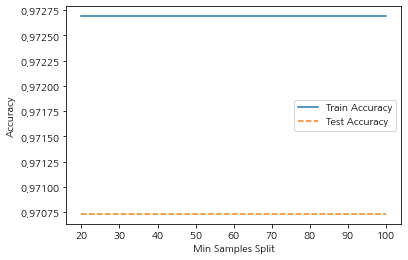

In [104]:
#모델 설명력 그래프로 확인

plt.plot(para_split, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('Accuracy');plt.xlabel('Min Samples Split')
plt.legend()

### 분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 변화 없으므로, 특정 값을 지정하지 않는다.

In [107]:
#모델 parameter 조정
#min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

train_accuracy =[] #train 설명력 결과 저장
test_accuracy=[] #test 설명력 결과 저장

para_leaf = [n_leaf*5 for n_leaf in range(1,11)]
for v_min_samples_leaf in para_leaf :
    gb=GradientBoostingClassifier(random_state=1234, n_estimators=20, learning_rate =0.1, max_depth=5, min_samples_leaf=v_min_samples_leaf )
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x,df_train_y))
    test_accuracy.append(gb.score(df_test_x,df_test_y))
    
#결과 저장, 모델 설명력 확인
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] =para_leaf
df_accuracy_leaf['TrainAccuracy'] =train_accuracy
df_accuracy_leaf['TestAccuracy'] =test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.996,0.976
1,10,0.985,0.976
2,15,0.979,0.956
3,20,0.973,0.941
4,25,0.962,0.941
5,30,0.954,0.946
6,35,0.937,0.912
7,40,0.937,0.912
8,45,0.937,0.912
9,50,0.937,0.912


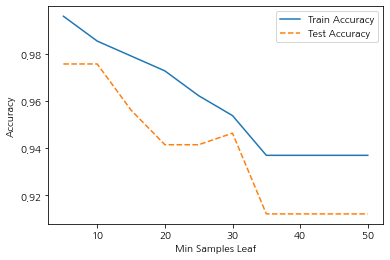

In [108]:
#모델 설명력 그래프로 확인

plt.plot(para_leaf, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('Accuracy');plt.xlabel('Min Samples Leaf')
plt.legend()

### 잎사귀 노드 최소 자료 수 증가에 따라 모델의 정확도는 감소한다.
### 그러나, 잎사귀 노드의 최소 자료 수를 증가시키면, 분리 조건이 엄격해져 과대적합이 방지된다.
### 따라서, Train과 Test 데이터 변화를 고려하여, 1을 선정한다.

In [111]:
#결론 도출
#최종 모델 생성
#트리 수는 20, 잎사귀 노드는 10, 최대 깊이는 5, 학습률은 0.1

gb_final=GradientBoostingClassifier(random_state=1234, n_estimators=20, learning_rate =0.1, max_depth=5, min_samples_leaf=1)
gb_final.fit(df_train_x,df_train_y)

#train 데이터 설명력
print('Accuracy on training set : {:.3f}'.format(gb_final.score(df_train_x,df_train_y)))
#test 데이터 설명력
print('Accuracy on test set : {:.3f}'.format(gb_final.score(df_test_x,df_test_y)))

Accuracy on training set : 0.994
Accuracy on test set : 0.980


### train 데이터의 과대적합 경향성을 방지하기 위해, parameter을 선정하여, train 데이터의 정확도가 99.4%
### test 데이터의 정확도가 98.0% 로 parameter 미지정보다 더 낮은 정확도를 가졌지만, train 데이터의 과대적합 경향성은 방지하였다.

In [112]:
#설명변수의 중요도 : feature_importances_
#tree.feature_importances_ :설명변수의 중요도 확인 및 테이블로 저장
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] =v_feature_name
df_importance['Importance'] =gb_final.feature_importances_

#df_feature_importance 의 테이블을 중요도 순으로 정렬
df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)


,Feature,Importance
11,ROLLING_TEMP_T5,0.737
7,FUR_SZ_TEMP,0.126
0,PT_THK,0.055
12,ROLLING_DESCALING,0.048
9,FUR_TIME,0.013
1,PT_WDTH,0.008
8,FUR_SZ_TIME,0.005
3,PT_WGT,0.005
19,WORK_GR_1조,0.003
2,PT_LTH,0.000


Text(0, 0.5, '변수')

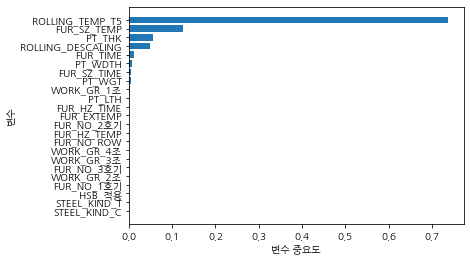

In [113]:
#설명변수 중요도 그래프
#중요도가 높은 변수를 상위에 그림

df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

## 그래디언트 부스팅을 기반으로 한, 설명변수 중요도 분석이다.
## 이는, 분석한 모델에 따라, ROLLING_TEMP_T5, FUR_SZ_TEMP, PT_THK, ROLLING_DESCALING 순으로 영향이 크다고 해석 할 수 있다.
단, 계산된 변수의 중요도가 낮아도, 선택되는 데이터에 따라 중요도가 변경 될 수 있으므로, 중요하지 않은 데이터로 단정지어선 안된다.